In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qiskit

2023-06-06 16:30:02.206348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


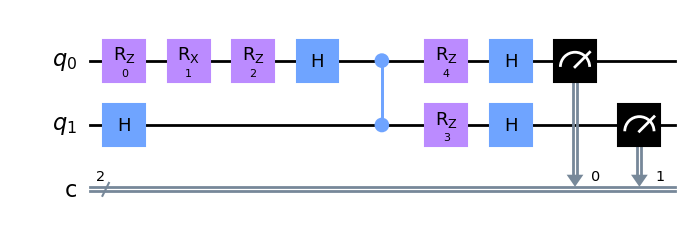

In [2]:
dev = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev)
def circuit(x):
    qml.Hadamard(wires=1)
    qml.RZ(0,wires=0)
    qml.RX(1,wires=0)
    qml.RZ(2,wires=0)
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(3,wires=1)
    qml.RZ(4,wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)   
    return qml.expval(qml.PauliZ(0))

circuit([0,1,2,3,4])

dev._circuit.draw(output="mpl")

In [3]:
dev1 = qml.device('default.mixed', wires=2)

In [4]:
def real():
    qml.Hadamard(wires=1) 

In [5]:
def generator(w,**kwargs):
    qml.RZ(w[0],wires=0)
    qml.RX(w[1],wires=0)
    qml.RZ(w[2],wires=0)
    qml.DepolarizingChannel(p,wires=0)

In [6]:
def discriminator(w,**kwargs):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(w[0],wires=1)
    qml.RZ(w[1],wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)
    qml.DepolarizingChannel(p,wires=0)
    qml.DepolarizingChannel(p,wires=1)

In [7]:
@qml.qnode(dev1, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))

In [8]:
p = 0.1
print(qml.draw(real_gen_disc_circuit)([ 0,0,0],[ 0,0]))

0: ──RZ(0.00)──RX(0.00)──RZ(0.00)──DepolarizingChannel(0.10)──H─╭Z──RZ(0.00)──H
1: ──H──────────────────────────────────────────────────────────╰●──RZ(0.00)──H

───DepolarizingChannel(0.10)─┤ ╭<𝓗>
───DepolarizingChannel(0.10)─┤ ╰<𝓗>


In [9]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [10]:
def disc_cost(disc_weights):
    cost =1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [11]:
@qml.qnode(dev1, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev1, interface="tf")
def circuit_rs():
    real()
    return qml.state()

In [12]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))
    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

# train only generator while discriminator is a perfect swap frozen discriminator
loss_val_d = []
loss_val_g = []
step_d = []
step_gf = []
sg_f =[]
epochs = 6
a = 30
for i in range(epochs):            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a)
            step_gf.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg_f.append(state_fidelity)
            
perfect_swap = sg_f
perfect_step_g = step_gf            

2023-06-06 16:30:23.547198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Step 0: cost = 0.249991027517831
Step 5: cost = 0.2499793317179169
Step 10: cost = 0.24995637457257003
Step 15: cost = 0.24990956191656938
Step 20: cost = 0.24981329332628494
Step 25: cost = 0.2496150777595066
Step 30: cost = 0.24920740782768552
Step 35: cost = 0.2483715397213876
Step 40: cost = 0.2466688307847657
Step 45: cost = 0.24324605227716567
Step 50: cost = 0.23654617490523944
Step 55: cost = 0.22409270003546192
Step 60: cost = 0.2030456947787141
Step 65: cost = 0.17269823092480158
Step 70: cost = 0.13785326289727953
Step 75: cost = 0.10720156897555017
Step 80: cost = 0.08613061749898163
Step 85: cost = 0.07404903868811144
Step 90: cost = 0.06784621342540353
Step 95: cost = 0.06484416230338891
Step 100: cost = 0.06343306220640782
Step 105: cost = 0.06277893017442143
Step 110: cost = 0.06247765626715093
Step 115: cost = 0.06233931255065783
Step 120: cost = 0.06227587293625747
Step 125: cost = 0.06224680007333827
Step 130: cost = 0.062233480523550544
Step 135: cost = 0.0622273790

In [13]:
#step_g

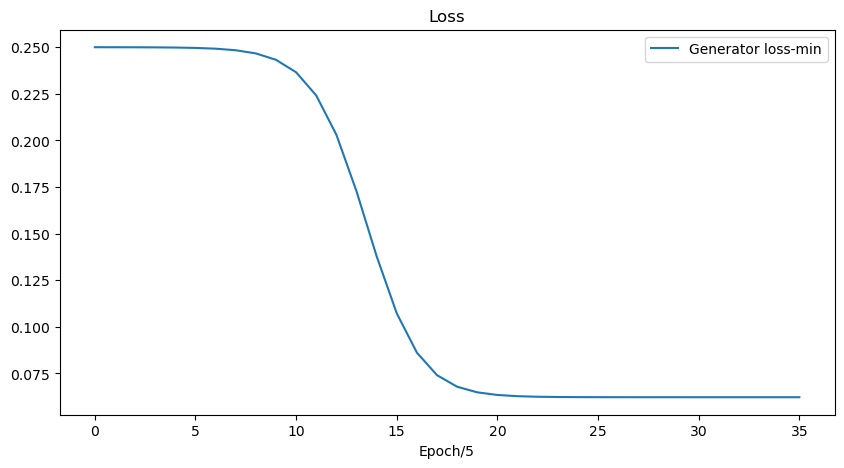

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_gf)), loss_val_g, label="Generator loss-min")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch/5")
plt.legend()
plt.show()

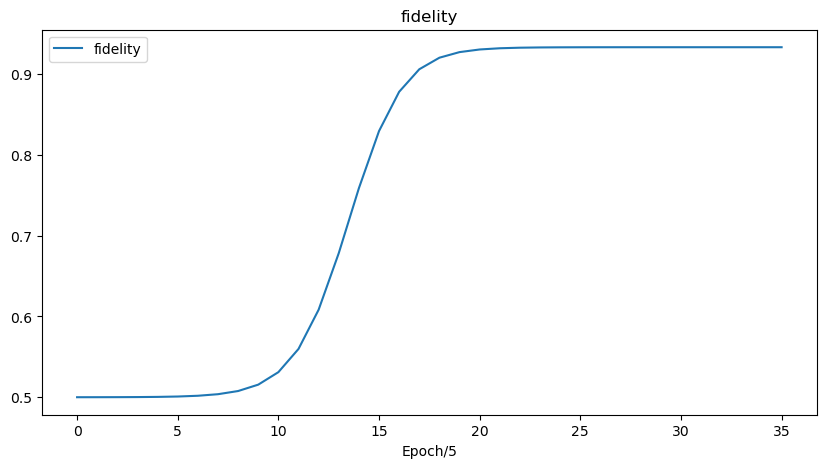

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(perfect_step_g)), perfect_swap, label="fidelity")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch/5")
plt.legend()
plt.show()

In [16]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 3
a1 = 40
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 2     
a2 = 10
a3 = 10
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1

    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+ a1*epochs1 + a2*(i+1)+ a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
           

Step 0: cost = 0.249991027517831
Step 5: cost = 0.2499793317179169
Step 10: cost = 0.24995637457257003
Step 15: cost = 0.24990956191656938
Step 20: cost = 0.24981329332628494
Step 25: cost = 0.2496150777595066
Step 30: cost = 0.24920740782768552
Step 35: cost = 0.2483715397213876
Step 40: cost = 0.2466688307847657
Step 45: cost = 0.24324605227716567
Step 50: cost = 0.23654617490523944
Step 55: cost = 0.22409270003546192
Step 60: cost = 0.2030456947787141
Step 65: cost = 0.17269823092480158
Step 70: cost = 0.13785326289727953
Step 75: cost = 0.10720156897555017
Step 80: cost = 0.08613061749898163
Step 85: cost = 0.07404903868811144
Step 90: cost = 0.06784621342540353
Step 95: cost = 0.06484416230338891
Step 100: cost = 0.06343306220640782
Step 105: cost = 0.06277893017442143
Step 110: cost = 0.06247765626715093
Step 115: cost = 0.06233931255065783
Step 120: cost = 0.9377113927453515
Step 125: cost = 0.9376824641639897
Step 130: cost = 0.062342410528090225
Step 135: cost = 0.062280878216

In [17]:
#step_g

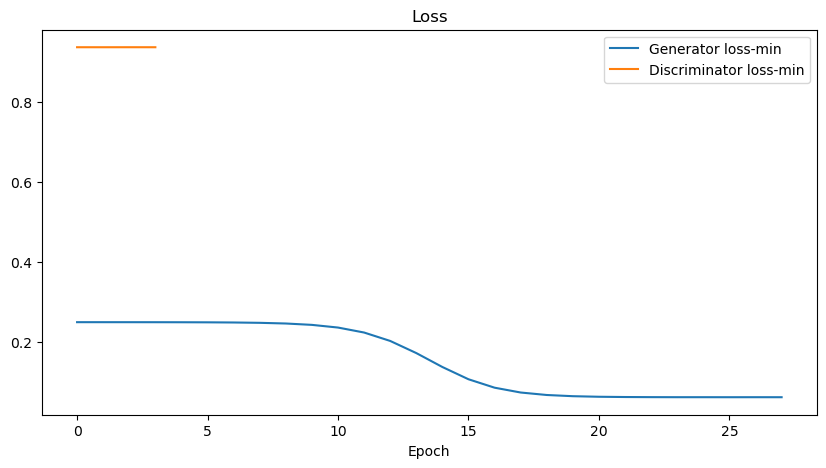

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

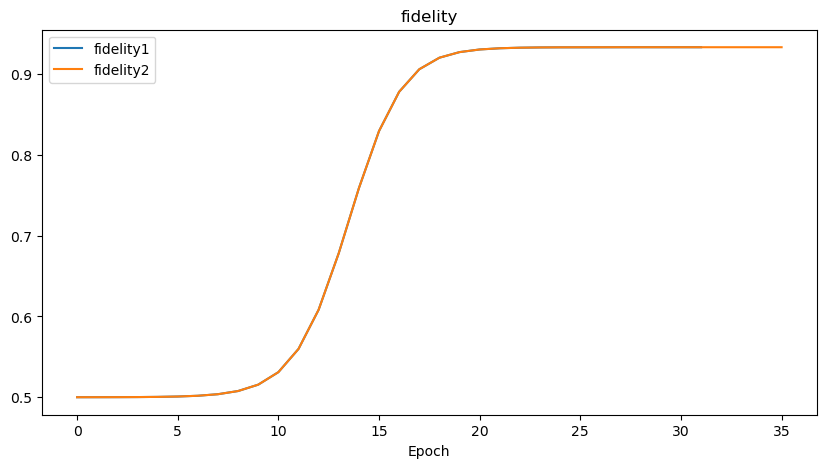

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="fidelity1")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="fidelity2")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [20]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 3
a1 = 40
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 8 
a2 = 2
a3 = 2
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
           

Step 0: cost = 0.249991027517831
Step 5: cost = 0.2499793317179169
Step 10: cost = 0.24995637457257003
Step 15: cost = 0.24990956191656938
Step 20: cost = 0.24981329332628494
Step 25: cost = 0.2496150777595066
Step 30: cost = 0.24920740782768552
Step 35: cost = 0.2483715397213876
Step 40: cost = 0.2466688307847657
Step 45: cost = 0.24324605227716567
Step 50: cost = 0.23654617490523944
Step 55: cost = 0.22409270003546192
Step 60: cost = 0.2030456947787141
Step 65: cost = 0.17269823092480158
Step 70: cost = 0.13785326289727953
Step 75: cost = 0.10720156897555017
Step 80: cost = 0.08613061749898163
Step 85: cost = 0.07404903868811144
Step 90: cost = 0.06784621342540353
Step 95: cost = 0.06484416230338891
Step 100: cost = 0.06343306220640782
Step 105: cost = 0.06277893017442143
Step 110: cost = 0.06247765626715093
Step 115: cost = 0.06233931255065783
Step 120: cost = 0.9377113927453515
Step 122: cost = 0.06228266162791482
Step 124: cost = 0.9377224247754072
Step 126: cost = 0.0622732444192

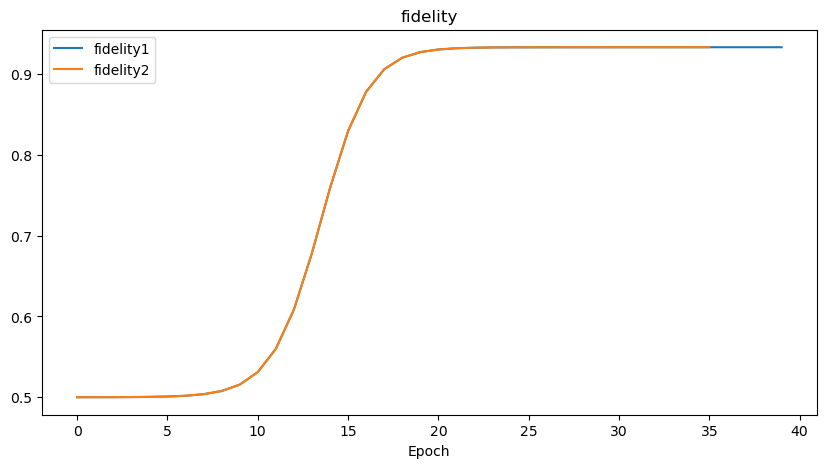

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="fidelity1")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="fidelity2")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()